# our imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import pickle
from tqdm import tqdm

# transforms for the images

In [2]:
# the transformations we will implement on our dataset at the beginning of loading them:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # flips the image w.r.t horizontal axis
    #transforms.RandomRotation(10), # rotates the image to a specified angel
    #transforms.RandomAutocontrast(),
    #transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # performs actions like zooms, change shear angles
    #transforms.RandomPerspective(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # set the color params
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# the device on which our codes will run:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# downloading the dataset

In [3]:
# we produce our original dataset. we don't use dataloader, because we like to be able to...
# ...modify the data in any way we please.

# download CIFAR10 dataset:

train_set = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transforms_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [01:47<00:00, 1580685.36it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


# extracting images/data from set object

In [4]:
# save all datapoints in numpy arrays for later uses:

x_train = np.array([np.array(datapoint[0]) for datapoint in train_set])
y_train = np.array([np.array(datapoint[1]) for datapoint in train_set])

x_test = np.array([np.array(datapoint[0]) for datapoint in test_set])
y_test = np.array([np.array(datapoint[1]) for datapoint in test_set])

print(f'{x_train.shape = }')
print(f'{y_train.shape = }')

print(f'{x_test.shape = }')
print(f'{y_test.shape = }')

x_train.shape = (50000, 3, 32, 32)
y_train.shape = (50000,)
x_test.shape = (10000, 3, 32, 32)
y_test.shape = (10000,)


# extracting the index of the frog in labels' file

In [5]:
# cat: 3
# frog: 6

label_names_file = open('data/cifar-10-batches-py/batches.meta', 'rb')
label_names = pickle.load(label_names_file)
label_names_file.close()

print(label_names)

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


# indices of frog data

In [6]:
# get indices of frogs in train and test sets:

indices_frogs_train = np.where(y_train == 6)[0]
indices_frogs_test = np.where(y_test == 6)[0]

print(indices_frogs_train.shape)
print(indices_frogs_test.shape)

(5000,)
(1000,)


# separating frog data from the rest

In [7]:
# separating frog data from the rest# seperate frogs from train and test sets:

x_train_frog = x_train[indices_frogs_train, :, :, :]
y_train_frog = y_train[indices_frogs_train]

x_test_frog = x_test[indices_frogs_test, :, :, :]
y_test_frog = y_test[indices_frogs_test]

print(f'{x_train_frog.shape = }')
print(f'{y_train_frog.shape = }')

print(f'{x_test_frog.shape = }')
print(f'{y_test_frog.shape = }')

print(np.unique(y_train_frog))

x_train_frog.shape = (5000, 3, 32, 32)
y_train_frog.shape = (5000,)
x_test_frog.shape = (1000, 3, 32, 32)
y_test_frog.shape = (1000,)
[6]


In [8]:
# training and test data without frogs:

x_train_without_frog = np.delete(x_train, indices_frogs_train, axis=0)
y_train_without_frog = np.delete(y_train, indices_frogs_train)

x_test_without_frog = np.delete(x_test, indices_frogs_test, axis=0)
y_test_without_frog = np.delete(y_test, indices_frogs_test)


print(f'{x_train_without_frog.shape = }')
print(f'{y_train_without_frog.shape = }')

print(f'{x_test_without_frog.shape = }')
print(f'{y_test_without_frog.shape = }')

print(np.unique(y_train_without_frog))

x_train_without_frog.shape = (45000, 3, 32, 32)
y_train_without_frog.shape = (45000,)
x_test_without_frog.shape = (9000, 3, 32, 32)
y_test_without_frog.shape = (9000,)
[0 1 2 3 4 5 7 8 9]


# fixing the order in labels so the CUDA DSA error won't be thrown at us

In [9]:
# we assign class 6 (previously frog) to truck:

indices = np.where(y_train_without_frog == 9)[0]
y_train_without_frog[indices] = 6

indices = np.where(y_test_without_frog == 9)[0]
y_test_without_frog[indices] = 6

print(np.unique(y_train_without_frog))

print(np.unique(y_test_without_frog))

[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


# creating validation data

In [10]:
# split the datapoints into train (10%) and test (90%):

x_train_without_frog, x_valid_without_frog, y_train_without_frog, y_valid_without_frog = train_test_split(x_train_without_frog, y_train_without_frog, test_size=0.1, stratify=y_train_without_frog, shuffle=True)

print(f'{x_train_without_frog.shape = }')
print(f'{y_train_without_frog.shape = }')

print(f'{x_valid_without_frog.shape = }')
print(f'{y_valid_without_frog.shape = }')

x_train_without_frog.shape = (40500, 3, 32, 32)
y_train_without_frog.shape = (40500,)
x_valid_without_frog.shape = (4500, 3, 32, 32)
y_valid_without_frog.shape = (4500,)


# creating dataloader for each phases of learning

In [11]:
# convert our numpy arrays to torch tensor and create dataset and data loader from them:

x_train_without_frog = torch.from_numpy(x_train_without_frog)
y_train_without_frog = torch.from_numpy(y_train_without_frog)

x_valid_without_frog = torch.from_numpy(x_valid_without_frog)
y_valid_without_frog = torch.from_numpy(y_valid_without_frog)

x_test_without_frog = torch.from_numpy(x_test_without_frog)
y_test_without_frog = torch.from_numpy(y_test_without_frog)

# convert torch tensor to torch dataset and then torch data loader:

train_set = TensorDataset(x_train_without_frog, y_train_without_frog)
valid_set = TensorDataset(x_valid_without_frog, y_valid_without_frog)
test_set = TensorDataset(x_test_without_frog, y_test_without_frog)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# creating our model, optimizer and learning rate scheduler objects

In [40]:
# the implementation of ResNet18 is taken from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=9):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [18]:
#'''
model = torchvision.models.resnet18(pretrained=True)

model.fc = nn.Linear(512, 9)
model = model.to(device)
#''';

In [19]:
#model = ResNet18()
#model = model.to(device)

optimizer = optim.Adam(params=model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# training and evaluation process

In [20]:
epochs = 200

# lists to keep track of losses and accuracies during training:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(1, epochs + 1):
    # a counter to efficiently calculate loss:
    counter = 0
    
    # set the model on training mode, so the gradients can be updated:
    model.train()
    
    print(f'Epoch {epoch} of {epochs}')
    
    # to calculate loss and accuracy for whole epoch:
    train_running_loss = 0.0
    train_running_correct = 0
    
    for data, labels in train_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # preparing for training and validation:
        optimizer.zero_grad()
        
        # forward-pass:
        output = model(data)
        
        # calculating the loss:
        loss = criterion(output, labels)
        
        # backpropagation:
        loss.backward()
        
        # updating the weights:
        optimizer.step()
        
        # calculating the accuracy for the epoch:
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        
        # calculating the loss for the epoch:
        train_running_loss += loss.item()

    # training loss and accuracy for the whole epoch:
    epoch_train_loss = train_running_loss / counter
    epoch_train_acc = 100.0 * (train_running_correct / len(train_loader.dataset))
    
    print(f'Training Loss: {epoch_train_loss:.3f}, Training Accuracy: {epoch_train_acc:.3f}')
    
    # set the model to evaluation mode:
    model.eval()
    
    # we don't want gradients being updated:
    with torch.no_grad():
        # loss and accuracy for whole validation or test set:
        valid_running_loss = 0.0
        valid_running_correct = 0

        # a counter to efficiently calculate loss:
        counter = 0
        
        for data, labels in valid_loader:
            counter += 1
            
            # read data and labels, and move them to gpu:
            data = data.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            
            # forward-pass:
            output = model(data)
            
            # calculating the loss:
            loss = criterion(output, labels)

            # calculating the accuracy for the epoch:
            _, preds = torch.max(output.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            
            # calculating the loss for the epoch:
            valid_running_loss += loss.item()

        # loss and accuracy for the whole epoch:
        epoch_valid_loss = valid_running_loss / counter
        epoch_valid_acc = 100.0 * (valid_running_correct / len(valid_loader.dataset))
        
        print(f'Validation Loss: {epoch_valid_loss:.3f}, Validation Accuracy: {epoch_valid_acc:.3f}')
        
        print('-' * 50)
        
    lr_scheduler.step()   
    
    # save results in corresponding lists:
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_acc)

Epoch 1 of 200
Training Loss: 2.179, Training Accuracy: 21.985
Validation Loss: 1.869, Validation Accuracy: 30.222
--------------------------------------------------
Epoch 2 of 200
Training Loss: 1.742, Training Accuracy: 33.474
Validation Loss: 1.587, Validation Accuracy: 38.511
--------------------------------------------------
Epoch 3 of 200
Training Loss: 1.533, Training Accuracy: 41.067
Validation Loss: 1.461, Validation Accuracy: 45.133
--------------------------------------------------
Epoch 4 of 200
Training Loss: 1.344, Training Accuracy: 49.573
Validation Loss: 1.382, Validation Accuracy: 49.778
--------------------------------------------------
Epoch 5 of 200
Training Loss: 1.196, Training Accuracy: 55.267
Validation Loss: 1.173, Validation Accuracy: 57.000
--------------------------------------------------
Epoch 6 of 200
Training Loss: 1.075, Training Accuracy: 60.240
Validation Loss: 1.163, Validation Accuracy: 57.778
--------------------------------------------------
Epoc

KeyboardInterrupt: 

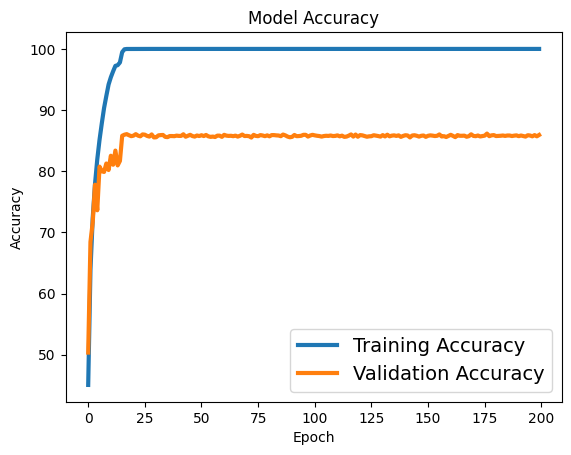

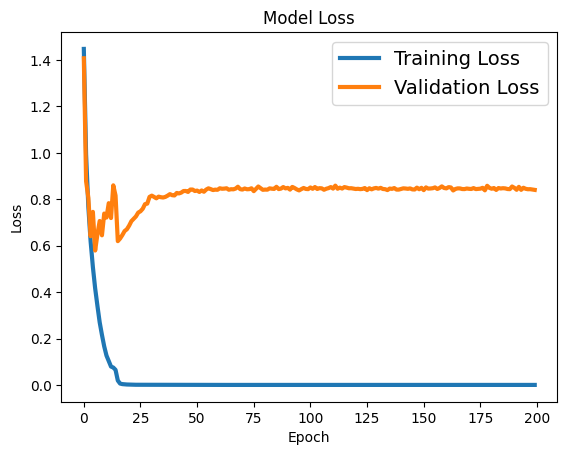

In [44]:
# plot accuracy progress for both training and validation:

plt.plot(train_acc, label='Training Accuracy', linewidth=3)
plt.plot(valid_acc, label='Validation Accuracy', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best', fontsize=14)
plt.show()

# plot loss progress for both training and validation:

plt.plot(train_loss, label='Training Loss', linewidth=3)
plt.plot(valid_loss, label='Validation Loss', linewidth=3)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=14)
plt.show()

In [45]:
# evaluate the model on test-set:

# set the model to evaluation mode:
model.eval()

model_outputs = []

with torch.no_grad():
    # loss and accuracy for whole validation or test set:
    test_running_loss = 0.0
    test_running_correct = 0

    # a counter to efficiently calculate loss:
    counter = 0
    
    for data, labels in test_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # forward-pass:
        output = model(data)
        
        model_outputs += output
        
        # calculating the loss:
        loss = criterion(output, labels)

        # calculating the accuracy for the epoch:
        _, preds = torch.max(output.data, 1)
        test_running_correct += (preds == labels).sum().item()
        
        # calculating the loss for the epoch:
        test_running_loss += loss.item()

    # loss and accuracy for the whole epoch:
    test_loss = test_running_loss / counter
    test_acc = 100.0 * (test_running_correct / len(test_loader.dataset))
    
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

Test Loss: 0.887, Test Accuracy: 86.078


# saving and loading the model

In [46]:
torch.save(model, 'model without frog.pt')

In [59]:
model = torch.load('model without frog.pt')

# process of saving outputs of the model for original test data

In [60]:
# evaluate the model on test-set:

# set the model to evaluation mode:
model.eval()

model_outputs = []

with torch.no_grad():
    # loss and accuracy for whole validation or test set:
    test_running_loss = 0.0
    test_running_correct = 0

    # a counter to efficiently calculate loss:
    counter = 0
    
    for data, labels in test_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # forward-pass:
        output = model(data)
        
        model_outputs += output

# passing the outputs of the model through softmax to get the logits

In [61]:
model_outputs = torch.stack(model_outputs, 0)
softmax_logits = F.softmax(model_outputs, 1)

print(softmax_logits)
print(softmax_logits.size())

tensor([[9.5831e-12, 2.3130e-08, 4.2878e-13,  ..., 5.6399e-11, 1.8543e-12,
         9.4944e-08],
        [1.6739e-09, 1.6869e-07, 3.6465e-16,  ..., 9.7675e-14, 5.5484e-15,
         1.0000e+00],
        [4.8456e-09, 1.2216e-09, 2.5134e-12,  ..., 8.8180e-12, 5.8022e-14,
         1.0000e+00],
        ...,
        [1.3157e-16, 1.3796e-12, 4.9632e-13,  ..., 1.4898e-15, 9.1996e-13,
         2.0125e-14],
        [4.6172e-06, 9.9999e-01, 1.2151e-06,  ..., 1.5371e-10, 2.3217e-10,
         5.0038e-12],
        [1.7775e-14, 2.6393e-12, 5.4417e-16,  ..., 2.4951e-16, 1.0000e+00,
         3.4480e-16]], device='cuda:0')
torch.Size([9000, 9])


# getting the maximum probability value in the logits

In [62]:
softmax_logits_max = torch.max(softmax_logits, 1)[0]

print(softmax_logits_max)
print(softmax_logits_max.size())

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')
torch.Size([9000])


# finding a suitable threshold, so that maximum probability above that threshold is considered to be inlier data

In [63]:
threshold = np.percentile(softmax_logits_max.cpu(), 5)
print(threshold)

0.7523964792490007


# checking if we found the threshold correctly

In [64]:
inlier_indices = softmax_logits_max >= threshold
print(inlier_indices)
print(inlier_indices.shape)

print(np.where(inlier_indices.cpu() == True)[0].shape)

print(f'Inlier Percentage = {np.where(inlier_indices.cpu() == True)[0].shape[0] / softmax_logits_max.size(0) * 100}%')

tensor([True, True, True,  ..., True, True, True], device='cuda:0')
torch.Size([9000])
(8550,)
Inlier Percentage = 95.0%


# now, creating a dataloader for frogs' class

In [66]:
# create dataloader for frogs' class:

x_test_frog = torch.from_numpy(x_test_frog)
y_test_frog = torch.from_numpy(y_test_frog)

test_set_frog = TensorDataset(x_test_frog, y_test_frog)
test_loader_frog = DataLoader(test_set_frog, batch_size=128, shuffle=False)

# process of saving outputs of the model for frogs' test data

In [67]:
# get the output of model for frogs:

# set the model to evaluation mode:
model.eval()

model_ouputs_frog = []

with torch.no_grad():
    for data, labels in test_loader_frog:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # forward-pass:
        output = model(data)
        
        model_ouputs_frog += output

# passing the outputs of the model through softmax to get the logits

In [68]:
# get the output of model for frogs and pass it through softmax to get frogs' logits:

model_ouputs_frog = torch.stack(model_ouputs_frog, 0)
softmax_logit_frogs = F.softmax(model_ouputs_frog, 1)

print(softmax_logit_frogs)
print(softmax_logit_frogs.size())

tensor([[2.7395e-08, 1.8699e-06, 1.8477e-02,  ..., 3.6256e-06, 1.0693e-10,
         1.1387e-05],
        [3.6126e-11, 8.6772e-07, 2.1900e-08,  ..., 2.8992e-07, 1.2899e-06,
         1.0819e-07],
        [5.1834e-06, 3.0171e-07, 2.0631e-01,  ..., 3.2509e-07, 4.6540e-07,
         6.6202e-08],
        ...,
        [1.6351e-06, 1.9549e-10, 1.6919e-01,  ..., 5.0322e-09, 2.7898e-10,
         3.8083e-10],
        [1.3778e-08, 1.2713e-01, 1.1103e-02,  ..., 1.5094e-04, 1.6089e-09,
         9.4931e-05],
        [2.7991e-06, 2.3978e-05, 8.9205e-01,  ..., 5.2535e-06, 2.1634e-06,
         6.3813e-03]], device='cuda:0')
torch.Size([1000, 9])


# getting the maximum probability value in the logits

In [69]:
softmax_logits_frogs_max = torch.max(softmax_logit_frogs, 1)[0]

print(softmax_logits_frogs_max)
print(softmax_logits_frogs_max.size())

tensor([0.8985, 0.9990, 0.7937, 1.0000, 1.0000, 0.9996, 0.9619, 0.9918, 1.0000,
        1.0000, 0.9718, 0.9877, 0.9767, 1.0000, 0.9645, 0.8063, 0.7884, 0.7992,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9992, 1.0000, 1.0000, 0.9996, 0.5328,
        0.4946, 0.9928, 0.9087, 1.0000, 0.9398, 1.0000, 0.5112, 0.7620, 0.6160,
        0.7183, 0.9999, 0.9975, 0.9419, 0.6033, 0.6252, 0.9999, 0.9999, 0.7908,
        0.9518, 0.9720, 0.8288, 0.9999, 0.9603, 0.8582, 0.5964, 0.9922, 0.9941,
        0.9395, 0.9999, 1.0000, 0.9460, 0.7749, 0.9942, 0.9886, 0.9241, 0.6142,
        0.9998, 0.9478, 0.9306, 0.9988, 0.6622, 0.9077, 0.9853, 0.9924, 0.9998,
        0.6701, 0.9998, 1.0000, 0.9890, 0.8543, 0.9848, 1.0000, 0.6162, 0.9787,
        0.9958, 0.8602, 0.3546, 1.0000, 0.9994, 1.0000, 0.8208, 0.7026, 0.9894,
        0.8762, 0.6460, 0.9987, 0.8233, 0.9962, 0.9658, 0.7157, 1.0000, 0.9969,
        1.0000, 0.5636, 0.9999, 0.9498, 0.9429, 0.6176, 0.9985, 0.6642, 0.5655,
        0.5432, 0.9999, 1.0000, 0.9958, 

# comparing frogs' outlier data and finding a percentage which shows how many frogs' data is considered to be outlier

In [70]:
outlier_indices = softmax_logits_frogs_max < threshold
print(outlier_indices)
print(outlier_indices.shape)

print(np.where(outlier_indices.cpu() == True)[0].shape)

print(f'Outlier Percentage = {np.where(outlier_indices.cpu() == True)[0].shape[0] / softmax_logits_frogs_max.size(0) * 100}%')

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False, False,
        False, False, False,  True, False,  True,  True, False, False, False,
         True,  True, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False,  True, False, False,
        False, False,  True, False, False, False, False, False, False,  True,
        False, False, False,  True, False, False, False, False,  True, False,
        False,  True, False, False, False, False,  True, False, False, False,
         True, False, False, False,  True, False,  True,  True,  True, False,
        False, False, False,  True, False,  True, False, False, False, False,
         True, False,  True, False, False, False, False, False, 